In [1]:
import pandas as pd
# load the data
data = pd.read_csv(r"C:\Users\samue\OneDrive\Desktop\Data Science FP\Preprocessing\2021-2024 data.csv")

In [2]:
# Checking  for the datatype and missing values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1352 entries, 0 to 1351
Data columns (total 35 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Player   1352 non-null   object 
 1   Nation   1352 non-null   object 
 2   Pos      1352 non-null   object 
 3   Squad    1352 non-null   object 
 4   Age      1352 non-null   int64  
 5   Born     1352 non-null   int64  
 6   GCA      1352 non-null   int64  
 7   GCA90    1352 non-null   float64
 8   Gls      1352 non-null   int64  
 9   G-PK     1352 non-null   int64  
 10  Sh       1352 non-null   int64  
 11  SoT      1352 non-null   int64  
 12  SoT%     1352 non-null   float64
 13  Sh/90    1352 non-null   float64
 14  SoT/90   1352 non-null   float64
 15  G/Sh     1352 non-null   float64
 16  G/SoT    1352 non-null   float64
 17  Dist     1352 non-null   float64
 18  PK       1352 non-null   int64  
 19  PKatt    1352 non-null   int64  
 20  xG       1352 non-null   float64
 21  npxG     1352 

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters: {'criterion': 'friedman_mse', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
Test Mean Squared Error: 0.0030683912464124644
Test R-squared: 0.9358712572256045
    Feature  Importance
6      G/Sh    0.648023
5    SoT/90    0.179242
9     xG/90    0.064075
4     Sh/90    0.047734
2       90s    0.032149
8        PK    0.010669
10  np:G-xG    0.006612
7     G/SoT    0.005847
11     Dist    0.001921
0       Pos    0.001305
15  Cluster    0.000734
1       Age    0.000544
3     GCA90    0.000478
14   Season    0.000357
13   Nation    0.000239
12    Squad    0.000071


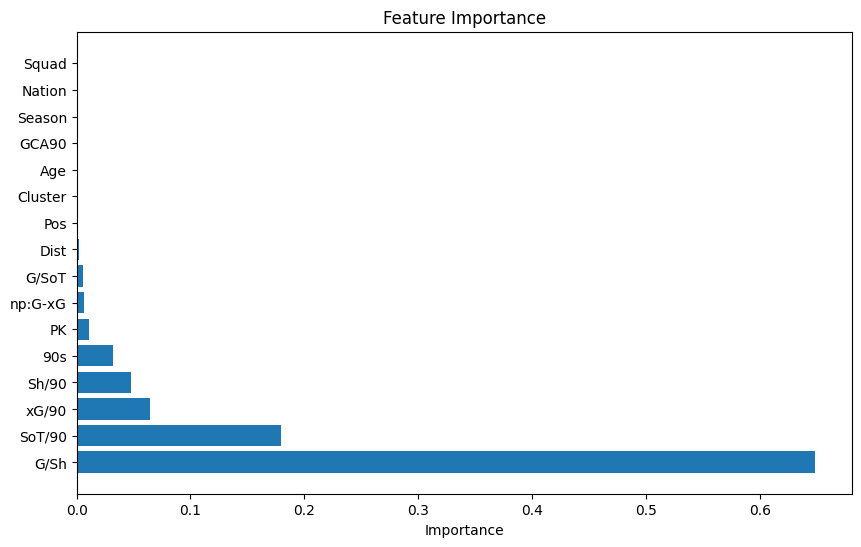

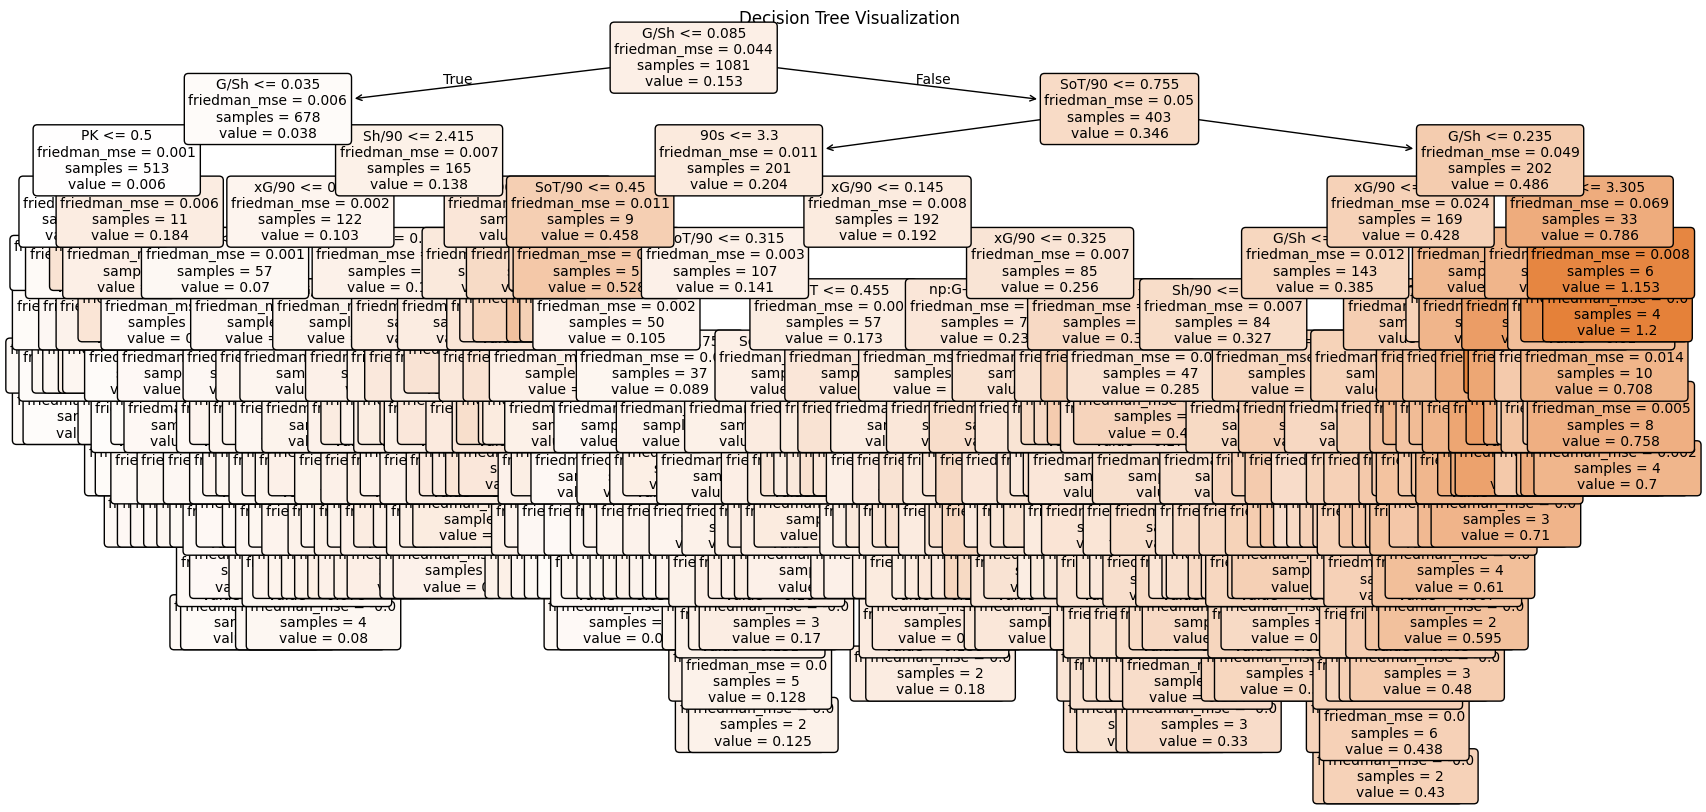

In [3]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


# Selecting the features and target
features = ['Pos','Age','90s','GCA90','Sh/90','SoT/90','G/Sh','G/SoT','PK','xG/90','np:G-xG','Dist','Squad','Nation', 'Season','Cluster']
target = 'Gls/90'

# Apply a cap to the target variable to filter out outliers from the dataset
data['Gls/90'] = data['Gls/90'].apply(lambda x: min(x, 1.2))

# Encode categorical features
label_encoders = {}
for col in ['Nation', 'Pos', 'Squad', 'Season']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Define features as X and target as Y
X = data[features]
y = data[target]

# Initialize the DecisionTreeRegressor model
model = DecisionTreeRegressor(random_state=42)

# Making the hyperparameter grid for tuning the hyperparameters
param_grid = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
}


# Use GridSearchCV to tune hyperparameters with 5-fold cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)

# Fit the model with the best hyperparameters
grid_search.fit(X, y)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best Parameters: {best_params}")

# Creating train-test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the best model on training set
best_model.fit(X_train, y_train)

# Evaluating on test set
y_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"Test Mean Squared Error: {test_mse}")
print(f"Test R-squared: {test_r2}")


# Creating the feature importance
importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

# Visualize the Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(best_model, feature_names=features, filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree Visualization')
plt.show()



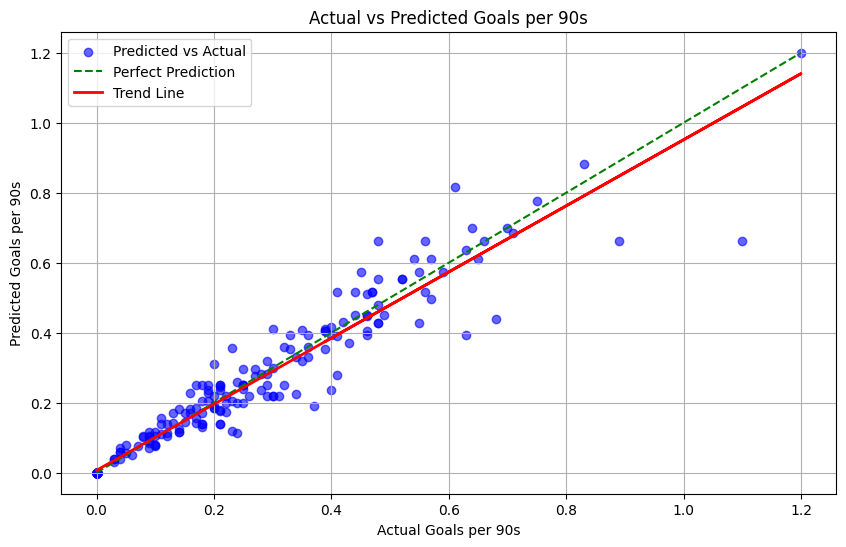

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Create a scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual', alpha=0.6)

# Plot the line of perfect prediction
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='green', label='Perfect Prediction', linestyle='--')

# Fitting a trend line using linear regression 
trend_model = LinearRegression()
y_test_reshaped = np.array(y_test).reshape(-1, 1)  
trend_model.fit(y_test_reshaped, y_pred)  
trend_line = trend_model.predict(y_test_reshaped)  

# Adding the trend line into the plot
plt.plot(y_test, trend_line, color='red', label='Trend Line', linewidth=2)

# Adding labels, title, and legend
plt.xlabel('Actual Goals per 90s')
plt.ylabel('Predicted Goals per 90s')
plt.title('Actual vs Predicted Goals per 90s')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

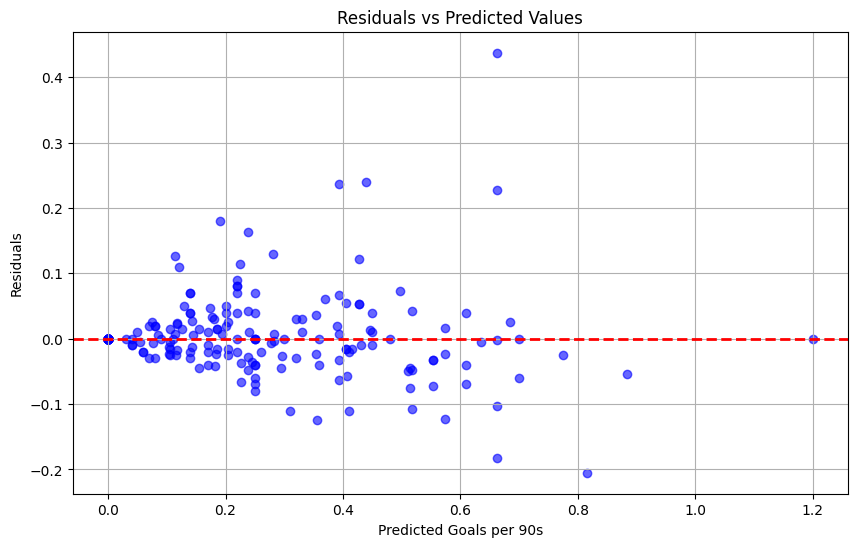

In [5]:
# Plotting residuals
# Formula for calculating the residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue', alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Goals per 90s')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.grid(True)
plt.show()